In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline  
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.feature_selection import RFE

# Data

In [2]:
# Read all data
all_data_selection = pd.read_csv('fama_french_data.csv', index_col=0, dtype={0:'str'})
all_data_selection.index = pd.to_datetime(all_data_selection.index, format='%Y%m')
X_all = all_data_selection.iloc[:,8:]
y_SMB_bin = all_data_selection['SMB_bin']
y_HML_bin = all_data_selection['HML_bin']

feature_names = X_all.columns
index_names = X_all.index

In [3]:
# Normalize all features
scalar_all = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(X_all)
X_all_scaled = scalar_all.transform(X_all)

## Function - Annual Re-fitting with Feature Selection

In [4]:
random_state = 302

In [5]:
def select_features(features, X_train_all, y_train_all):
    valid_score = pd.DataFrame(index = ['accuracy'], columns = features)
    valid_score[:] = 0
    
    for j in reversed(range(1,51,1)):
        X_train = X_train_all[:-j,:]
        X_valid = X_train_all[-j,:]

        y_train = y_train_all[:-j]
        y_valid = y_train_all[-j]
        
        for f in features:
            estimator = LogisticRegression(random_state=random_state, penalty='l2', C=f)
            selector = estimator.fit(X_train, y_train)
            valid_score.loc['accuracy',f] += 1/50 * selector.score(X_valid.reshape(1, -1), y_valid.flatten())
    
    best_C = valid_score.idxmax(axis=1)[0]
    #print("Best C is: ", best_C)
    estimator_select = LogisticRegression(random_state=random_state, penalty='l2', C=best_C)
    selector_select_fit = estimator_select.fit(X_train_all, y_train_all)
    valid_error = 1 - valid_score.max(axis=1)
    #print('validation error is:', valid_error)
    return best_C, selector_select_fit

In [6]:
def annual_prediction_model(features, sliding_window, years, X_all, y_all):
    feature_pick = pd.DataFrame(index=range(1, years+1), columns=feature_names)
    test_error = pd.DataFrame(index = ['Test_accuracy', 'C', 'Train_accuracy'], columns = range(1, years+1))
    test_error[:] = 0
    pred_period = index_names[-years*12:]
    pred_array = np.empty(0)
    for year in reversed(range(1,years+1,1)):
        train_year_end = - 12 * year
        train_year_beg = - sliding_window + train_year_end
        X_year = X_all[train_year_beg:,:]
        y_year = y_all[train_year_beg:]
        
        X_year_train = X_year[:sliding_window,:] 
        X_year_test = X_year[sliding_window:sliding_window+12,:]
        
        y_year_train = y_year[:sliding_window]
        y_year_test = y_year[sliding_window:sliding_window+12]
        
        C_year, model_year = select_features(features, X_year_train, y_year_train)
        accuracy_year = model_year.score(X_year_test, y_year_test)
        test_error.loc['Test_accuracy', year] = accuracy_year
        test_error.loc['Train_accuracy', year] = model_year.score(X_year_train, y_year_train)
        test_error.loc['C', year] = C_year
        feature_pick.loc[year,] = np.absolute(model_year.coef_)
        pred_array = np.append(pred_array, model_year.predict(X_year_test))
    
    pred_array = pred_array.reshape(-1,1)
    predictions = pd.DataFrame(pred_array, index = pred_period, columns = ['Predictions'])
                               
    return feature_pick, test_error, predictions

# Remove Ind_Ret, CPI, PPI

In [7]:
X_red = X_all

In [8]:
feature_names = X_red.columns

In [9]:
# Normalize all features
scalar_red = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(X_red)
X_red_scaled = scalar_red.transform(X_red)

In [10]:
features = [0.1, 0.2, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]

In [11]:
feature_pick_SMB_red, test_error_SMB_red, pred_SMB_red = annual_prediction_model(features, 400, 30, X_red_scaled, y_SMB_bin)
feature_pick_HML_red, test_error_HML_red, pred_HML_red = annual_prediction_model(features, 400, 30, X_red_scaled, y_HML_bin)

In [12]:
y_SMB_HML = np.where((all_data_selection['SMB'] - all_data_selection['HML']) >= 0, 1, 0)
feature_pick_SMBHML_red, test_error_SMBHML_red, pred_SMBHML_red = annual_prediction_model(features, 400, 30, X_red_scaled, y_SMB_HML)

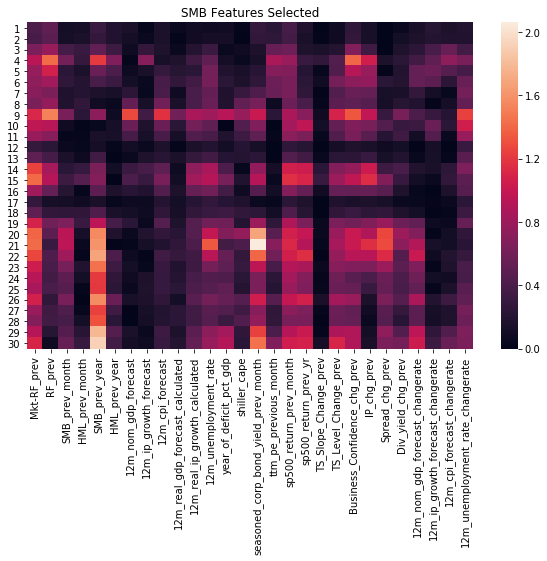

In [13]:
fig, ax = plt.subplots(figsize=(10,6)) 
sns.heatmap(feature_pick_SMB_red.astype('float64'), ax=ax, vmin = 0, vmax=feature_pick_SMB_red.max().max())
ax.set_title('SMB Features Selected')
feature_pick_SMB_red.to_csv('../Results/Feature Importance/Regression_L2_30yr_400window_SMB.csv')

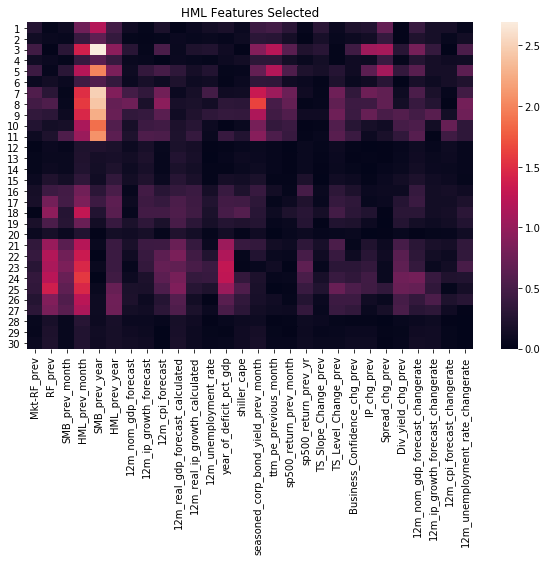

In [14]:
fig, ax = plt.subplots(figsize=(10,6)) 
sns.heatmap(feature_pick_HML_red.astype('float64'), ax=ax, vmin = 0, vmax=feature_pick_HML_red.max().max())
ax.set_title('HML Features Selected')
feature_pick_HML_red.to_csv('../Results/Feature Importance/Regression_L2_30yr_400window_HML.csv')

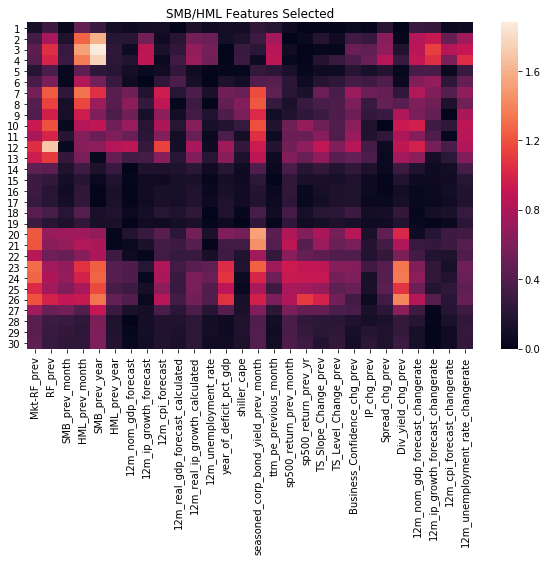

In [15]:
fig, ax = plt.subplots(figsize=(10,6)) 
sns.heatmap(feature_pick_SMBHML_red.astype('float64'), ax=ax, vmin = 0, vmax=feature_pick_SMBHML_red.max().max())
ax.set_title('SMB/HML Features Selected')
feature_pick_SMBHML_red.to_csv('../Results/Feature Importance/Regression_L2_30yr_400window_SMBHML.csv')

## Compared to Passive Strategies

### SMB

In [16]:
SMB_invest_red = pred_SMB_red.merge(pd.DataFrame(all_data_selection.loc[:,'SMB']), right_index=True, left_index=True, how='left')
SMB_invest_red['Active'] = np.where(SMB_invest_red['Predictions'] == 1, 1 + SMB_invest_red['SMB'], 1 - 1 * SMB_invest_red['SMB'])
SMB_invest_red['Passive'] = 1 + SMB_invest_red['SMB']

SMB_return_red = SMB_invest_red.loc[:,['Active', 'Passive']]
SMB_invest_annual_red = (SMB_return_red.reset_index(drop=True)
                               .groupby(by = np.arange(len(SMB_return_red.index))//12, axis=0).agg(['prod','sum']))

SMB_invest_annual_red

Active            Passive         
        prod      sum      prod      sum
0   1.018596  12.0207  0.937612  11.9379
1   1.225227  12.2065  0.834099  11.8221
2   1.240833  12.2198  1.097978  12.0976
3   0.968634  11.9744  0.970961  11.9768
4   1.163654  12.1541  1.119344  12.1153
5   1.039368  12.0402  1.020214  12.0216
6   1.122300  12.1173  0.955579  11.9565
7   0.943395  11.9465  0.977415  11.9819
8   1.083946  12.0898  0.965708  11.9742
9   1.306840  12.2730  0.756748  11.7270
10  0.961152  11.9662  1.028308  12.0338
11  0.538048  11.4483  1.073988  12.1307
12  0.973931  11.9823  1.009128  12.0177
13  1.103942  12.1091  1.184495  12.1793
14  1.257003  12.2326  1.186152  12.1746
15  0.977305  11.9805  1.020663  12.0239
16  0.995177  11.9982  1.036426  12.0388
17  0.952661  11.9553  0.981940  11.9855
18  1.019636  12.0206  0.966026  11.9666
19  1.049100  12.0501  1.053305  12.0541
20  1.069238  12.0706  1.069238  12.0706
21  0.992274  11.9981  1.061497  12.0655
22  0.978696  11.9812  0.978696  11.9812
23  0.941644  11.9413  1.008131  12.0095
24  1.073106  12.0719  1.073106  12.0719
25  0.881904  11.8780  0.881904  11.8780
26  1.164333  12.1561  1.016625  12.0205
27  1.038468  12.0403  1.038468  12.0403
28  1.006930  12.0115  1.006930  12.0115
29  1.011803  12.0153  1.011803  12.0153

In [17]:
SMB_invest_annual_red.columns = SMB_invest_annual_red.columns.map('|'.join)
SMB_invest_annual_red.loc[:,['Active|sum','Passive|sum']] = SMB_invest_annual_red.loc[:,['Active|sum','Passive|sum']]/12
print(SMB_invest_annual_red.loc[:,['Active|prod','Passive|prod']].prod())
print(SMB_invest_annual_red.loc[:,['Active|sum','Passive|sum']].mean())

Active|prod     2.148529
Passive|prod    1.226015
dtype: float64
Active|sum     1.002638
Passive|sum    1.001056
dtype: float64


### HML

In [18]:
HML_invest_red = pred_HML_red.merge(pd.DataFrame(all_data_selection.loc[:,'HML']), right_index=True, left_index=True, how='left')
HML_invest_red['Active'] = np.where(HML_invest_red['Predictions'] == 1, 1 + HML_invest_red['HML'], 1 - 1 * HML_invest_red['HML'])
HML_invest_red['Passive'] = 1 + HML_invest_red['HML']

HML_return_red = HML_invest_red.loc[:,['Active', 'Passive']]
HML_invest_annual_red = (HML_return_red.reset_index(drop=True)
                               .groupby(by = np.arange(len(HML_return_red.index))//12, axis=0).agg(['prod','sum']))

HML_invest_annual_red

Active            Passive         
        prod      sum      prod      sum
0   0.995702  11.9970  0.995702  11.9970
1   0.910106  11.9078  0.910106  11.9078
2   0.912248  11.9094  0.912248  11.9094
3   1.109942  12.1106  1.158776  12.1536
4   1.146981  12.1433  1.173445  12.1661
5   1.000265  12.0017  1.000265  12.0017
6   1.005166  12.0067  1.005166  12.0067
7   0.979890  11.9824  0.979890  11.9824
8   1.145918  12.1407  1.145918  12.1407
9   1.073166  12.0739  1.073166  12.0739
10  0.821011  11.8078  0.821011  11.8078
11  0.938826  11.9656  0.915978  11.9408
12  1.540664  12.4567  1.540664  12.4567
13  0.995652  12.0022  1.077111  12.0808
14  0.897008  11.8939  0.934181  11.9345
15  1.124633  12.1196  1.124633  12.1196
16  1.096120  12.0929  1.096120  12.0929
17  1.084450  12.0825  1.084450  12.0825
18  0.930786  11.9299  0.930786  11.9299
19  0.954812  11.9593  1.068940  12.0719
20  0.887640  11.8992  0.911597  11.9258
21  1.001321  12.0053  0.917843  11.9183
22  0.935155  11.9353  0.908241  11.9061
23  0.969464  11.9695  1.030449  12.0305
24  0.988388  11.9906  1.067106  12.0672
25  1.055867  12.0561  1.018327  12.0199
26  1.096853  12.0955  0.906075  11.9045
27  0.932214  11.9320  1.000047  12.0022
28  1.024976  12.0322  1.037579  12.0444
29  1.132386  12.1262  0.878662  11.8726

In [19]:
HML_invest_annual_red.columns = HML_invest_annual_red.columns.map('|'.join)
HML_invest_annual_red.loc[:,['Active|sum','Passive|sum']] = HML_invest_annual_red.loc[:,['Active|sum','Passive|sum']]/12
print(HML_invest_annual_red.loc[:,['Active|prod','Passive|prod']].prod())
print(HML_invest_annual_red.loc[:,['Active|sum','Passive|sum']].mean())

Active|prod     1.603501
Passive|prod    1.484516
dtype: float64
Active|sum     1.001738
Passive|sum    1.001523
dtype: float64


### Switching SMB/HML

In [20]:
SMBHML_invest_red = pred_SMBHML_red.merge(all_data_selection.loc[:,['SMB','HML']], right_index=True, left_index=True, how='left')
SMBHML_invest_red['Active'] = np.where(SMBHML_invest_red['Predictions'] == 1, 1 + SMBHML_invest_red['SMB'], 1 + 1 * SMBHML_invest_red['HML'])
SMBHML_invest_red['Passive_SMB'] = 1 + SMBHML_invest_red['SMB']
SMBHML_invest_red['Passive_HML'] = 1 + SMBHML_invest_red['HML']
SMBHML_invest_red['Passive_Equal_Weight'] = 0.5* (SMBHML_invest_red['Passive_SMB'] + SMBHML_invest_red['Passive_HML'])

SMBHML_return_red = SMBHML_invest_red.loc[:,['Active', 'Passive_SMB','Passive_HML','Passive_Equal_Weight']]
SMBHML_invest_red_annual = (SMBHML_return_red.reset_index(drop=True)
                               .groupby(by = np.arange(len(SMBHML_return_red.index))//12, axis=0).agg(['prod','sum']))
SMBHML_invest_red_annual

Active          Passive_SMB          Passive_HML           \
        prod      sum        prod      sum        prod      sum   
0   0.995702  11.9970    0.937612  11.9379    0.995702  11.9970   
1   0.910106  11.9078    0.834099  11.8221    0.910106  11.9078   
2   1.075620  12.0759    1.097978  12.0976    0.912248  11.9094   
3   1.157474  12.1528    0.970961  11.9768    1.158776  12.1536   
4   1.237763  12.2185    1.119344  12.1153    1.173445  12.1661   
5   1.067665  12.0672    1.020214  12.0216    1.000265  12.0017   
6   0.994303  11.9956    0.955579  11.9565    1.005166  12.0067   
7   0.979890  11.9824    0.977415  11.9819    0.979890  11.9824   
8   1.145918  12.1407    0.965708  11.9742    1.145918  12.1407   
9   1.073166  12.0739    0.756748  11.7270    1.073166  12.0739   
10  0.821011  11.8078    1.028308  12.0338    0.821011  11.8078   
11  0.591721  11.5128    1.073988  12.1307    0.915978  11.9408   
12  1.532598  12.4513    1.009128  12.0177    1.540664  12.4567   
13  1.077111  12.0808    1.184495  12.1793    1.077111  12.0808   
14  0.934181  11.9345    1.186152  12.1746    0.934181  11.9345   
15  1.126289  12.1211    1.020663  12.0239    1.124633  12.1196   
16  1.037683  12.0380    1.036426  12.0388    1.096120  12.0929   
17  1.059292  12.0591    0.981940  11.9855    1.084450  12.0825   
18  0.945369  11.9455    0.966026  11.9666    0.930786  11.9299   
19  1.053305  12.0541    1.053305  12.0541    1.068940  12.0719   
20  1.069238  12.0706    1.069238  12.0706    0.911597  11.9258   
21  0.946733  11.9517    1.061497  12.0655    0.917843  11.9183   
22  1.011708  12.0141    0.978696  11.9812    0.908241  11.9061   
23  1.008131  12.0095    1.008131  12.0095    1.030449  12.0305   
24  1.056675  12.0565    1.073106  12.0719    1.067106  12.0672   
25  0.931548  11.9319    0.881904  11.8780    1.018327  12.0199   
26  1.049622  12.0521    1.016625  12.0205    0.906075  11.9045   
27  1.002841  12.0053    1.038468  12.0403    1.000047  12.0022   
28  1.050897  12.0570    1.006930  12.0115    1.037579  12.0444   
29  1.011803  12.0153    1.011803  12.0153    0.878662  11.8726   

   Passive_Equal_Weight            
                   prod       sum  
0              0.967054  11.96745  
1              0.872499  11.86495  
2              1.002611  12.00350  
3              1.063717  12.06520  
4              1.149226  12.14070  
5              1.011432  12.01165  
6              0.981101  11.98160  
7              0.981546  11.98215  
8              1.056769  12.05745  
9              0.903975  11.90045  
10             0.921317  11.92080  
11             1.030862  12.03575  
12             1.260555  12.23720  
13             1.134721  12.13005  
14             1.054086  12.05455  
15             1.072971  12.07175  
16             1.066869  12.06585  
17             1.033729  12.03400  
18             0.948639  11.94825  
19             1.062884  12.06300  
20             0.991593  11.99820  
21             0.988448  11.99190  
22             0.943803  11.94365  
23             1.019770  12.02000  
24             1.071068  12.06955  
25             0.949299  11.94895  
26             0.961169  11.96250  
27             1.020307  12.02125  
28             1.023774  12.02795  
29             0.944610  11.94395

In [21]:
SMBHML_invest_red_annual.columns = SMBHML_invest_red_annual.columns.map('|'.join)
SMBHML_invest_red_annual.loc[:,['Active|sum','Passive_SMB|sum','Passive_HML|sum','Passive_Equal_Weight|sum']] = \
                    SMBHML_invest_red_annual.loc[:,['Active|sum','Passive_SMB|sum','Passive_HML|sum','Passive_Equal_Weight|sum']]/12
print(SMBHML_invest_red_annual.loc[:,['Active|prod','Passive_SMB|prod','Passive_HML|prod','Passive_Equal_Weight|prod']].prod())
print(SMBHML_invest_red_annual.loc[:,['Active|sum','Passive_SMB|sum','Passive_HML|sum','Passive_Equal_Weight|sum']].mean())

Active|prod                  1.876698
Passive_SMB|prod             1.226015
Passive_HML|prod             1.484516
Passive_Equal_Weight|prod    1.495497
dtype: float64
Active|sum                  1.002169
Passive_SMB|sum             1.001056
Passive_HML|sum             1.001523
Passive_Equal_Weight|sum    1.001289
dtype: float64


# Summarize Results

In [22]:
summary_test_error = pd.DataFrame(index=['SMB', 'HML', 'SMB_HML_switch'], columns = test_error_SMB_red.columns)
summary_test_error.loc['SMB',:] = test_error_SMB_red.loc['Test_accuracy',:]
summary_test_error.loc['HML',:] = test_error_HML_red.loc['Test_accuracy',:]
summary_test_error.loc['SMB_HML_switch',:] = test_error_SMBHML_red.loc['Test_accuracy',:]

summary_test_error = summary_test_error.astype('float64').T
summary_test_error = summary_test_error.groupby(by = np.arange(len(summary_test_error.index))//5, axis=0).mean()
summary_test_error.loc['Mean',:] = summary_test_error.mean()
summary_test_error

,SMB,HML,SMB_HML_switch
0,0.566667,0.566667,0.566667
1,0.500000,0.466667,0.483333
2,0.533333,0.600000,0.466667
3,0.533333,0.516667,0.383333
4,0.650000,0.583333,0.616667
5,0.666667,0.483333,0.533333
Mean,0.575000,0.536111,0.508333


In [23]:
summary_invest_annual = pd.DataFrame(index=range(30), 
                                     columns = ['Active_SMB|mean','Active_HML|mean','Active_SMB_HML_Switch|mean',
                                                'Passive_SMB|mean','Passive_HML|mean', 'Passive_Equal_Weight|mean',
                                                'Active_SMB|prod','Active_HML|prod','Active_SMB_HML_Switch|prod',
                                                'Passive_SMB|prod','Passive_HML|prod', 'Passive_Equal_Weight|prod'])
summary_invest_annual.loc[:,'Active_SMB|mean'] = SMB_invest_annual_red.loc[:,'Active|sum']
summary_invest_annual.loc[:,'Active_HML|mean'] = HML_invest_annual_red.loc[:,'Active|sum']
summary_invest_annual.loc[:,'Active_SMB_HML_Switch|mean'] = SMBHML_invest_red_annual.loc[:,'Active|sum']
summary_invest_annual.loc[:,'Passive_SMB|mean'] = SMBHML_invest_red_annual.loc[:,'Passive_SMB|sum']
summary_invest_annual.loc[:,'Passive_HML|mean'] = SMBHML_invest_red_annual.loc[:,'Passive_HML|sum']
summary_invest_annual.loc[:,'Passive_Equal_Weight|mean'] = SMBHML_invest_red_annual.loc[:,'Passive_Equal_Weight|sum']
summary_invest_annual.loc[:,'Active_SMB|prod'] = SMB_invest_annual_red.loc[:,'Active|prod']
summary_invest_annual.loc[:,'Active_HML|prod'] = HML_invest_annual_red.loc[:,'Active|prod']
summary_invest_annual.loc[:,'Active_SMB_HML_Switch|prod'] = SMBHML_invest_red_annual.loc[:,'Active|prod']
summary_invest_annual.loc[:,'Passive_SMB|prod'] = SMBHML_invest_red_annual.loc[:,'Passive_SMB|prod']
summary_invest_annual.loc[:,'Passive_HML|prod'] = SMBHML_invest_red_annual.loc[:,'Passive_HML|prod']
summary_invest_annual.loc[:,'Passive_Equal_Weight|prod'] = SMBHML_invest_red_annual.loc[:,'Passive_Equal_Weight|prod']

summary_invest = pd.DataFrame(
                              columns = ['Active_SMB','Active_HML','Active_SMB_HML_Switch','Passive_SMB','Passive_HML',
                                         'Passive_Equal_Weight'])

summary_invest.loc['Mean-0',:] = np.array(summary_invest_annual.loc[:5,['Active_SMB|mean','Active_HML|mean','Active_SMB_HML_Switch|mean',
                                                           'Passive_SMB|mean','Passive_HML|mean', 'Passive_Equal_Weight|mean']].mean()).T
summary_invest.loc['Mean-1',:] = np.array(summary_invest_annual.loc[5:10,['Active_SMB|mean','Active_HML|mean','Active_SMB_HML_Switch|mean',
                                                           'Passive_SMB|mean','Passive_HML|mean', 'Passive_Equal_Weight|mean']].mean()).T
summary_invest.loc['Mean-2',:] = np.array(summary_invest_annual.loc[10:15,['Active_SMB|mean','Active_HML|mean','Active_SMB_HML_Switch|mean',
                                                           'Passive_SMB|mean','Passive_HML|mean', 'Passive_Equal_Weight|mean']].mean()).T
summary_invest.loc['Mean-3',:] = np.array(summary_invest_annual.loc[15:20,['Active_SMB|mean','Active_HML|mean','Active_SMB_HML_Switch|mean',
                                                           'Passive_SMB|mean','Passive_HML|mean', 'Passive_Equal_Weight|mean']].mean()).T
summary_invest.loc['Mean-4',:] = np.array(summary_invest_annual.loc[20:25,['Active_SMB|mean','Active_HML|mean','Active_SMB_HML_Switch|mean',
                                                           'Passive_SMB|mean','Passive_HML|mean', 'Passive_Equal_Weight|mean']].mean()).T
summary_invest.loc['Mean-5',:] = np.array(summary_invest_annual.loc[25:,['Active_SMB|mean','Active_HML|mean','Active_SMB_HML_Switch|mean',
                                                           'Passive_SMB|mean','Passive_HML|mean', 'Passive_Equal_Weight|mean']].mean()).T
summary_invest.loc['Mean',:] = np.array(summary_invest_annual.loc[:,['Active_SMB|mean','Active_HML|mean','Active_SMB_HML_Switch|mean',
                                                           'Passive_SMB|mean','Passive_HML|mean', 'Passive_Equal_Weight|mean']].mean()).T
summary_invest.loc['Cumulative-0',:] = np.array(summary_invest_annual.loc[:5,['Active_SMB|prod','Active_HML|prod','Active_SMB_HML_Switch|prod',
                                                'Passive_SMB|prod','Passive_HML|prod', 'Passive_Equal_Weight|prod']].product()).T
summary_invest.loc['Cumulative-1',:] = np.array(summary_invest_annual.loc[5:10,['Active_SMB|prod','Active_HML|prod','Active_SMB_HML_Switch|prod',
                                                'Passive_SMB|prod','Passive_HML|prod', 'Passive_Equal_Weight|prod']].product()).T
summary_invest.loc['Cumulative-2',:] = np.array(summary_invest_annual.loc[10:15,['Active_SMB|prod','Active_HML|prod','Active_SMB_HML_Switch|prod',
                                                'Passive_SMB|prod','Passive_HML|prod', 'Passive_Equal_Weight|prod']].product()).T
summary_invest.loc['Cumulative-3',:] = np.array(summary_invest_annual.loc[15:20,['Active_SMB|prod','Active_HML|prod','Active_SMB_HML_Switch|prod',
                                                'Passive_SMB|prod','Passive_HML|prod', 'Passive_Equal_Weight|prod']].product()).T
summary_invest.loc['Cumulative-4',:] = np.array(summary_invest_annual.loc[20:25,['Active_SMB|prod','Active_HML|prod','Active_SMB_HML_Switch|prod',
                                                'Passive_SMB|prod','Passive_HML|prod', 'Passive_Equal_Weight|prod']].product()).T
summary_invest.loc['Cumulative-5',:] = np.array(summary_invest_annual.loc[25:,['Active_SMB|prod','Active_HML|prod','Active_SMB_HML_Switch|prod',
                                                'Passive_SMB|prod','Passive_HML|prod', 'Passive_Equal_Weight|prod']].product()).T


summary_invest.loc['Cumulative',:] = np.array(summary_invest_annual.loc[:,['Active_SMB|prod','Active_HML|prod','Active_SMB_HML_Switch|prod',
                                                'Passive_SMB|prod','Passive_HML|prod', 'Passive_Equal_Weight|prod']].product()).T

summary_invest

,Active_SMB,Active_HML,Active_SMB_HML_Switch,Passive_SMB,Passive_HML,Passive_Equal_Weight
Mean-0,1.00855,1.00097,1.00582,0.999601,1.00188,1.00074
Mean-1,1.00601,1.00018,1.00094,0.995764,1.00018,0.997974
Mean-2,0.996097,1.00341,0.998726,1.00778,1.00472,1.00625
Mean-3,1.00105,1.00116,1.00401,1.00194,1.00309,1.00251
Mean-4,0.999182,0.998,1.00048,1.00107,0.998164,0.999615
Mean-5,1.00169,1.00403,1.00103,0.999427,0.997393,0.99841
Mean,1.00264,1.00174,1.00217,1.00106,1.00152,1.00129
Cumulative-0,1.8142,1.0527,1.49095,0.952118,1.12438,1.04596
Cumulative-1,1.49828,0.994718,1.05027,0.716074,0.994718,0.857249
Cumulative-2,0.683053,1.19277,0.843794,1.59818,1.31113,1.53647


# Other changes

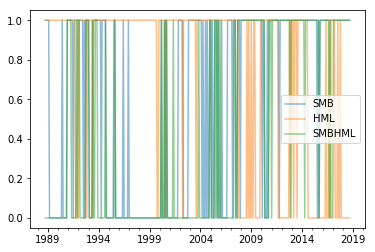

In [24]:
all_pred = pred_SMB_red.merge(pred_HML_red, right_index=True, left_index=True, how='inner')
all_pred = all_pred.merge(pred_SMBHML_red, right_index=True, left_index=True, how='inner')
all_pred.columns = ['SMB', 'HML', 'SMBHML']
all_pred.plot(alpha=0.5)


In [25]:
all_pred.to_csv('../Results/Regression_L2_30yr_400window.csv')

In [26]:
test_error_SMB_red.to_csv('../Results/Accuracy/Regression_L2_30yr_400window_SMB.csv')
test_error_HML_red.to_csv('../Results/Accuracy/Regression_L2_30yr_400window_HML.csv')
test_error_SMBHML_red.to_csv('../Results/Accuracy/Regression_L2_30yr_400window_SMBHML.csv')